In [2]:
import findspark
# TODO: your path will likely not have 'matthew' in it. Change it to reflect your path.
findspark.init('/home/chiziheng/spark-3.1.1-bin-hadoop2.7')

In [106]:
##########################Formatting Data##########################
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession\
        .builder\
        .appName("K-means")\
        .getOrCreate()
# Loads data.
dataset = spark.read.option('header',True).format("libsvm").csv("70N.csv", inferSchema=True)
dataset=dataset.drop('_c0','DateTime','Door','MotorTemp')
dataset.printSchema()
print(dataset.count())

vecAssembler = VectorAssembler(inputCols=dataset.columns, outputCol="features")
dataset = vecAssembler.transform(dataset)
dataset.show()

root
 |-- MotorCurrent: double (nullable = true)
 |-- OpenCloseStroke: integer (nullable = true)
 |-- MotorVoltage: integer (nullable = true)
 |-- SigOpenCommand: integer (nullable = true)
 |-- SigCloseCommand: integer (nullable = true)

22472
+------------+---------------+------------+--------------+---------------+--------------------+
|MotorCurrent|OpenCloseStroke|MotorVoltage|SigOpenCommand|SigCloseCommand|            features|
+------------+---------------+------------+--------------+---------------+--------------------+
|         1.6|            133|          47|             0|              1|[1.6,133.0,47.0,0...|
|         1.6|            133|          47|             0|              1|[1.6,133.0,47.0,0...|
|         0.0|            114|          48|             0|              1|[0.0,114.0,48.0,0...|
|         0.0|             95|          48|             0|              1|[0.0,95.0,48.0,0....|
|         0.0|             75|          48|             0|              1|[0.0,75.0,

In [101]:
##########################Scaling Data##########################
from pyspark.ml.feature import StandardScaler
scaler=StandardScaler(inputCol='features', outputCol='scaledFeatures',withStd=True,withMean=False)
scaledModel=scaler.fit(dataset)
df_final=scaledModel.transform(dataset)
# df_final.show(truncate=False)

In [102]:
##########################Train and Evaluation##########################
kmeans = KMeans(featuresCol='scaledFeatures').setK(3).setSeed(1)
model = kmeans.fit(df_final)

# Make predictions
predictions = model.transform(df_final)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.2190122847383824
Cluster Centers: 
[  0.97318078   1.75744135 101.08387154   1.99995578   0.        ]
[4.69516260e-04 1.10631502e-01 1.01682988e+02 1.02766879e+00
 9.72286993e-01]
[  0.92679148   1.75124382 101.12713307   0.           1.99995578]


![Silhouette](Silhouette.PNG)

In [104]:
##########################Find best number of Clusters##########################
silhouette_score=[]
for i in range(2,10):
    kmeans = KMeans(featuresCol='scaledFeatures').setK(i).setSeed(1)
    model = kmeans.fit(df_final)
    
    predictions=model.transform(df_final)
    
    evaluator=ClusteringEvaluator()
    
    Silhouette=evaluator.evaluate(predictions)
    
    silhouette_score.append(Silhouette)
silhouette_score

[0.0002241225491145532,
 0.2190122847383824,
 -0.12978334217301363,
 -0.13393551807749485,
 -0.20604235126795348,
 -0.20138273627897693,
 -0.26363871910328135,
 -0.2607085040269855]

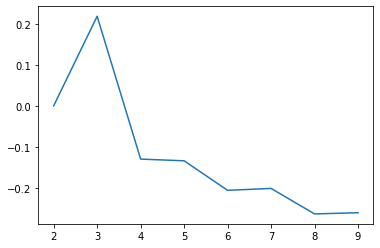

In [110]:
plt.plot([i for i in range(2,10)],silhouette_score)

In [ ]:
# for columns in dataset.columns:
#     dataset.schema[columns].nullable=False
#     dataset=dataset.withColumn(columns,dataset[columns].cast('float'))
#     dataset.filter(col(columns).isNull()).show()


# for columns in dataset.columns:
#     dataset.filter(col(columns).isNull()).show()

# dataset.show(truncate=False)